## MONICA Crop Model

--------------

Tasks:

* Отрисовать погоду для 2016 и 2017 годов 

* Отрисовать динамику биомассы ✅

* Сделать GA? 

* Отобразить динамику почвенных условий ✅

In [1]:
import os, sys
import json
import pandas as pd
import numpy as np 
import datetime as dt
import subprocess
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

 ## 1. Save weather in proper format for MONICA

In [203]:
# def weather_to_monica(src: str, dst: str): 
#     era5 = pd.read_csv(src)
#     era5['de-date'] = pd.to_datetime(era5['de-date'])
#     mask = era5['de-date']<'31.12.2017'
#     era5 = era5.loc[mask]
#     era5['de-date'] = pd.to_datetime(era5['de-date']).dt.strftime('%d.%m.%Y')
#     mask = era5['relhumid']>100
#     era5.loc[mask, 'relhumid']=99.99
#     era5.round(2).to_csv(dst, sep=';', index=False)
    
    
def weather_to_monica(src: str, dst: str, 
                      use_real_precip: bool = False,
                      correct_precip:bool=False,
                      use_history:bool=False,
                      reanalysis: str = '../monica/reanalysis.csv'): 
    weather = pd.read_csv(src)
    
    if use_real_precip: 
        era5 = pd.read_csv(reanalysis)
        if len(era5)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = era5.loc[:, 'precip'].copy()
        
    if use_history:
        hist = pd.read_csv('../monica/baseline_monica.csv')
        print('use hist')
        if len(hist)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = hist.loc[:, 'precip'].copy()
    weather.loc[:, 'de-date'] = pd.to_datetime(weather['de-date'])
    mask = weather['de-date']<'31.12.2017'
    weather = weather.loc[mask]
    weather['de-date'] = pd.to_datetime(weather['de-date']).dt.strftime('%d.%m.%Y')
    mask = weather['relhumid']>100
    weather.loc[mask, 'relhumid']=99.99
    if correct_precip:
        mask = weather['de-date']>'2017-01-01'
        sum_precip = weather.loc[mask, 'precip'].sum()
        print('sum_precip',sum_precip)
        diff = 633 - sum_precip
        to_add = diff/100
        index_to_add = weather.sample(frac=0.3).index
        weather.loc[index_to_add, 'precip'] = weather.loc[index_to_add, 'precip']+ to_add
#         weather['precip'] = weather['precip']+(diff/365)
        print(weather.iloc[-365:, :]['precip'].sum())
    weather.round(2).to_csv(dst, sep=';', index=False)
    return weather

## 2. Run MONICA model 

In [204]:
def run_monica(climate_fname: str, kind:str = 'ERA5', 
               use_real_precip:bool=False, 
               correct_precip:bool=False,
              use_history:bool=False)->pd.DataFrame:
    """
    run monica model 
    
    climate_fname: str - path to file with weather
    """
    path_monica = '../monica/monica_input/'
    dst = os.path.join(path_monica, "climate-monica.csv")
    
    weather = weather_to_monica(src=climate_fname,dst=dst, 
                                use_real_precip=use_real_precip,
                               correct_precip = correct_precip,use_history=use_history)
    weather.loc[:, 'weather'] = kind
    weather['de-date'] = pd.to_datetime(weather['de-date'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y' )))
    path_sim_file = '/home/monica/monica_input/sim-monica.json'
    cmd = 'monica-run'
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    daily_monica = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    daily_monica.loc[:, 'weather'] = kind
    final_monica = pd.read_csv('./out.csv', skiprows=1100, skipfooter=13, engine='python')
    final_monica.loc[:, 'weather'] = kind
    final_monica = final_monica.drop(axis=0, index=0)
    os.remove('./out.csv')
    return daily_monica, final_monica, weather

In [208]:
df_prophet, t_p, w_p = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                       kind='prophet')

df_prophet_corr, t_p_corr, w_p_corr = run_monica(climate_fname='../monica/prediction_monica.csv',
                                       kind='prophet_corr', correct_precip=True)


df_prophet_real, t_p_real, w_p_real = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                       kind='prophet_real_pr', use_real_precip=True)


df_baseline_monica, t_p_baseline, w_p_baseline = run_monica(climate_fname='../monica/baseline_monica.csv', 
                                       kind='baseline_monica')


df_neural_prophet, t_np, w_np = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                                     kind='Prophet+Hist', use_history=True)

df_neural_mp, t_mp, w_mp = run_monica(climate_fname='../monica/multi_prophet-monica.csv', 
                                                     kind='multi_prophet')



df_mean, t_m, w_m = run_monica(climate_fname='../monica/mean_era5.csv', 
                                                     kind='mean')



df_reanalysis, t_era5, w_era = run_monica(climate_fname='../monica/reanalysis.csv',
                                          kind='era5')

sum_precip 503.7831047410271
612.9403826751715
use hist


In [209]:
df = pd.concat([t_p, t_p_real,t_p_baseline, t_np,t_mp, t_m, t_era5, t_p_corr])
df

,CM-count,Crop,Yield,sowing,harvest,weather
1,1,soybean/000,3430.6,2016-04-15,2016-09-10,prophet
2,2,sugar beet/,17800.7,2017-05-02,2017-11-01,prophet
1,1,soybean/000,4630.9,2016-04-15,2016-09-10,prophet_real_pr
2,2,sugar beet/,24533.4,2017-05-02,2017-11-01,prophet_real_pr
1,1,soybean/000,3746.6,2016-04-15,2016-09-10,baseline_monica
2,2,sugar beet/,20872.8,2017-05-02,2017-11-01,baseline_monica
1,1,soybean/000,4583.2,2016-04-15,2016-09-10,Prophet+Hist
2,2,sugar beet/,29592.2,2017-05-02,2017-11-01,Prophet+Hist
1,1,soybean/000,2535.1,2016-04-15,2016-09-10,multi_prophet
2,2,sugar beet/,5038.8,2017-05-02,2017-11-01,multi_prophet


In [210]:
crop = 'sugar beet/'

mask = df_reanalysis['Crop']==crop
sb_era5 = df_reanalysis.loc[mask]

mask = df_neural_prophet['Crop']==crop
sb_np = df_neural_prophet.loc[mask]

mask = df_prophet_corr['Crop']==crop
sb_corr = df_prophet_corr.loc[mask]

mask = df_baseline_monica['Crop']==crop
sb_baseline = df_baseline_monica.loc[mask]

mask = df_prophet['Crop']==crop
sb_n = df_prophet.loc[mask]

mask = df_mean['Crop']==crop
sb_m = df_mean.loc[mask]


mask = df_neural_mp['Crop']==crop
sb_mp = df_neural_mp.loc[mask]

mask = df_prophet_real['Crop']==crop
sb_pr = df_prophet_real.loc[mask]



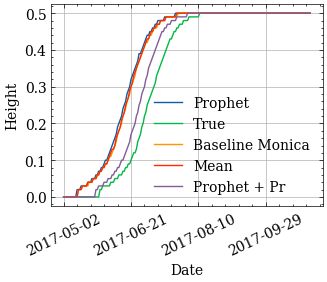

In [211]:
var = 'Height'
# sb_np.set_index('Date')[var].plot(label='Neural prophet')
sb_n.set_index('Date')[var].plot(label='Prophet')
sb_era5.set_index('Date')[var].plot(label='True')
sb_baseline.set_index('Date')[var].plot(label='Baseline Monica')
sb_m.set_index('Date')[var].plot(label='Mean')
# sb_mp.set_index('Date')[var].plot(label='Multi')
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

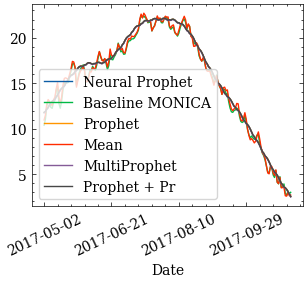

In [212]:
var = 'Tavg'
sb_np.set_index('Date')[var].plot(label='Neural Prophet')
sb_baseline.set_index('Date')[var].plot(label='Baseline MONICA')
sb_n.set_index('Date')[var].plot(label='Prophet')
sb_m.set_index('Date')[var].plot(label='Mean')
sb_mp.set_index('Date')[var].plot(label='MultiProphet')
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr')
plt.legend(frameon=True)
plt.xticks(rotation=25)
plt.show()

## 3. Plots and analytics

In [213]:
!pip -q install SciencePlots


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [214]:
import scienceplots

In [215]:
plt.style.use(['science', 'no-latex'])

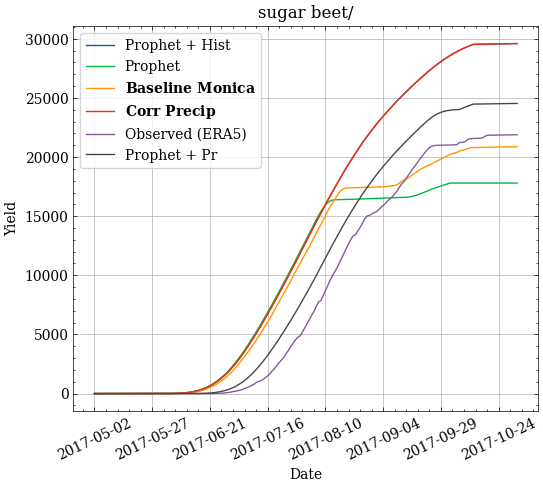

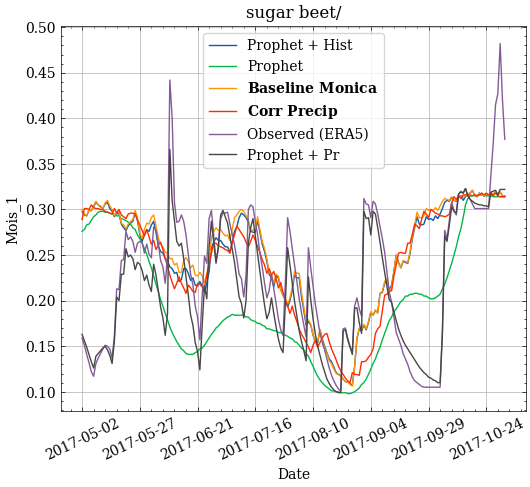

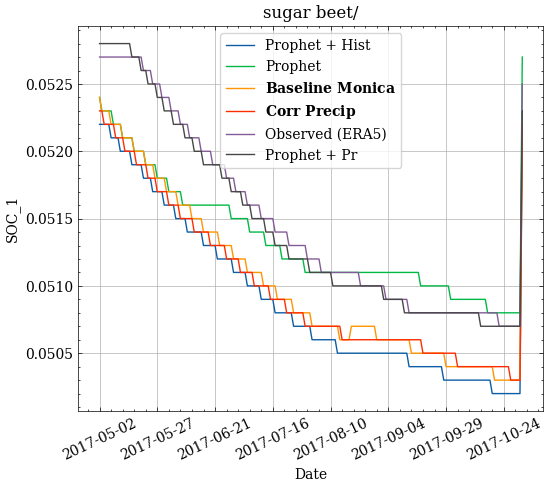

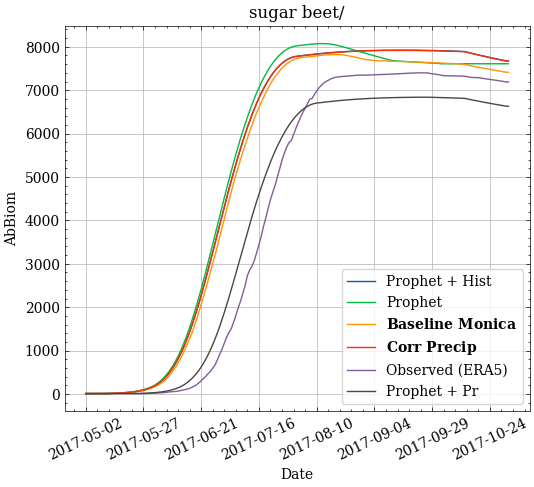

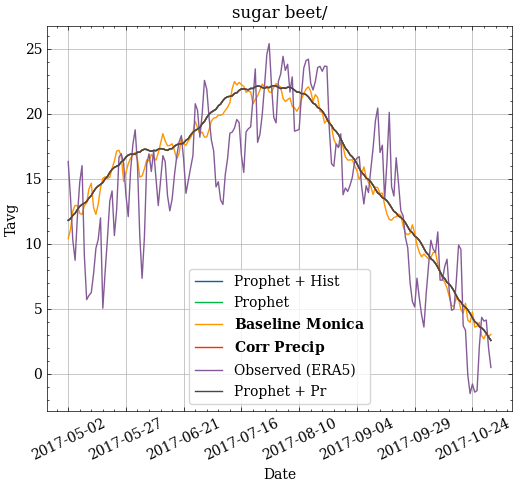

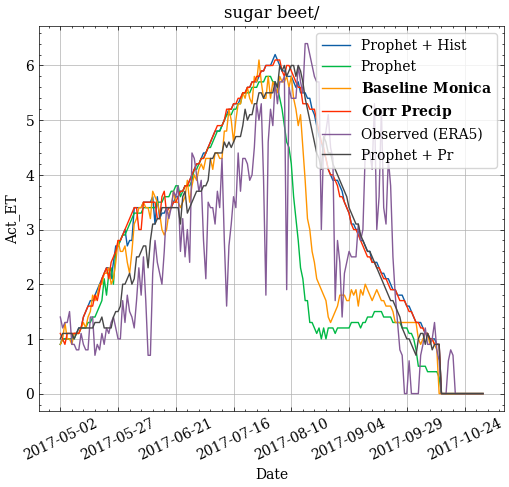

In [216]:
variables = ['Yield', 'Mois_1', 'SOC_1', 'AbBiom', 'Tavg', 'Act_ET']
for var in variables:
    fig, ax = plt.subplots(1,1,figsize = (6,5))
    sb_np.set_index('Date')[var].plot(label='Prophet + Hist', ax=ax)
    sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
    sb_baseline.set_index('Date')[var].plot(label="$\\bf{Baseline\  Monica}$", ax=ax)
    sb_corr.set_index('Date')[var].plot(label="$\\bf{Corr\  Precip}$", ax=ax)
    sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
    
#     sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax, )
#     sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
    sb_pr.set_index('Date')[var].plot(label='Prophet + Pr',ax=ax)
    plt.ylabel(var)
    ax.legend(frameon=True)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
#           ncol=3, fancybox=True, shadow=True, frameon=True)
    ax.set_title(crop)
    plt.xticks(rotation=25)
    plt.grid()
    plt.show()

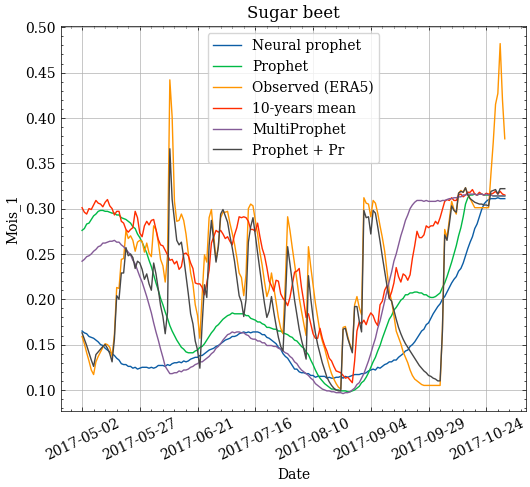

In [148]:


var = 'Mois_1'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr',ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [40]:
print(list(sb_era5.columns))

['Date', 'Crop', 'TraDef', 'Tra', 'NDef', 'HeatRed', 'FrostRed', 'OxRed', 'Stage', 'TempSum', 'VernF', 'DaylF', 'IncRoot', 'IncLeaf', 'IncShoot', 'IncFruit', 'RelDev', 'LT50', 'AbBiom', 'OrgBiom/Root', 'OrgBiom/Leaf', 'OrgBiom/Shoot', 'OrgBiom/Fruit', 'Yield', 'GroPhot', 'NetPhot', 'MaintR', 'GrowthR', 'StomRes', 'Height', 'LAI', 'RootDep', 'EffRootDep', 'TotBiomN', 'AbBiomN', 'SumNUp', 'ActNup', 'PotNup', 'NFixed', 'Target', 'CritN', 'AbBiomNc', 'YieldNc', 'Protein', 'NPP', 'NPP/Root', 'NPP/Leaf', 'NPP/Shoot', 'NPP/Fruit', 'GPP', 'Ra', 'Ra/Root', 'Ra/Leaf', 'Ra/Shoot', 'Ra/Fruit', 'Mois_1', 'Mois_2', 'Mois_3', 'Mois_4', 'Mois_5', 'Mois_6', 'Mois_7', 'Mois_8', 'Mois_9', 'Mois_10', 'Mois_11', 'Mois_12', 'Mois_13', 'Mois_14', 'Mois_15', 'Mois_16', 'Mois_17', 'Mois_18', 'Mois_19', 'Mois_20', 'Precip', 'Irrig', 'Infilt', 'Surface', 'RunOff', 'SnowD', 'FrostD', 'ThawD', 'PASW_1', 'PASW_2', 'PASW_3', 'PASW_4', 'PASW_5', 'PASW_6', 'PASW_7', 'PASW_8', 'PASW_9', 'PASW_10', 'PASW_11', 'PASW_12',

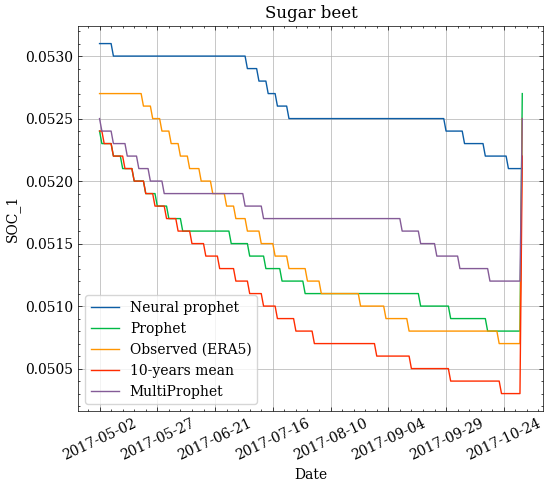

In [41]:


var = 'SOC_1'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

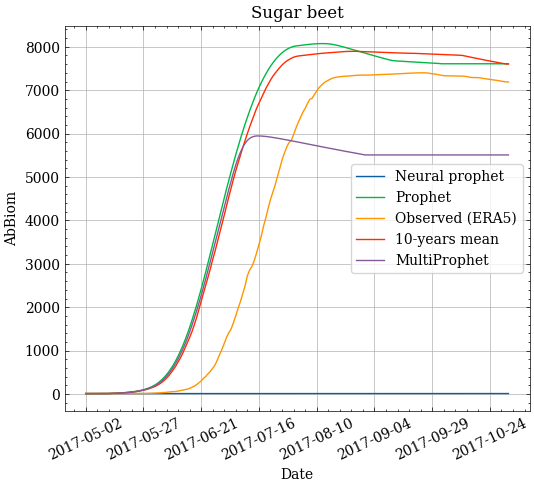

In [42]:


var = 'AbBiom'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

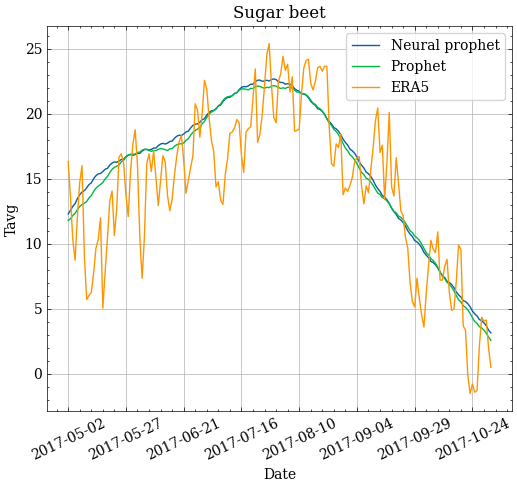

In [43]:
var = 'Tavg'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [44]:
sb_n.columns[-20:]

Index(['CBal_1', 'Nmin_1', 'Nmin_2', 'Nmin_3', 'NetNmin', 'Denit', 'N2O',
       'SoilpH', 'NEP', 'NEE', 'Rh', 'Tmin', 'Tavg', 'Tmax', 'Wind', 'Globrad',
       'Relhumid', 'Sunhours', 'NFert', 'weather'],
      dtype='object')

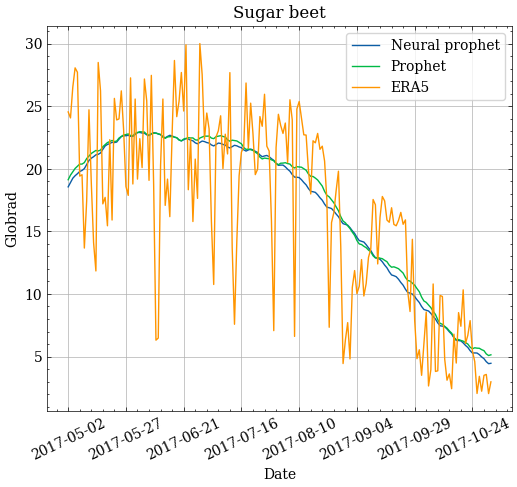

In [45]:
var = 'Globrad'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

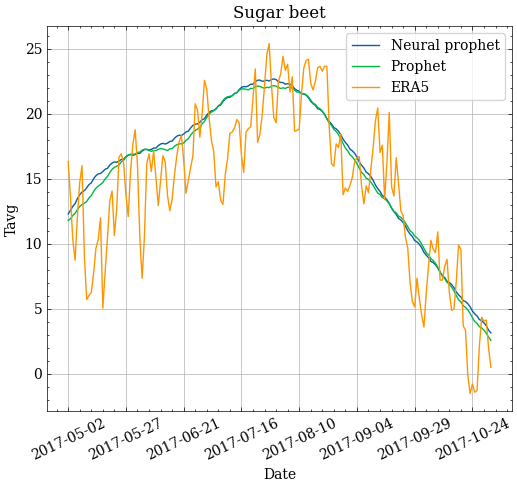

In [46]:
var = 'Tavg'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

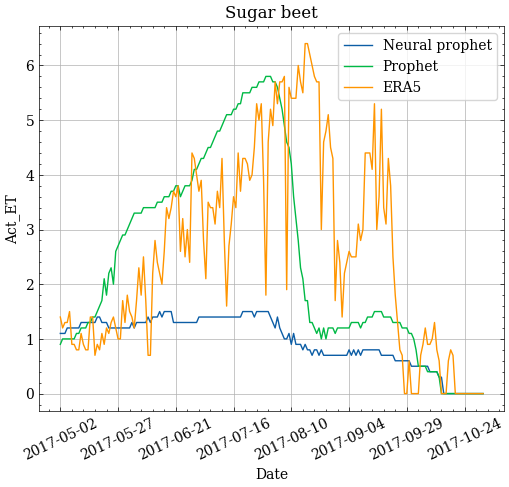

In [47]:
var = 'Act_ET'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

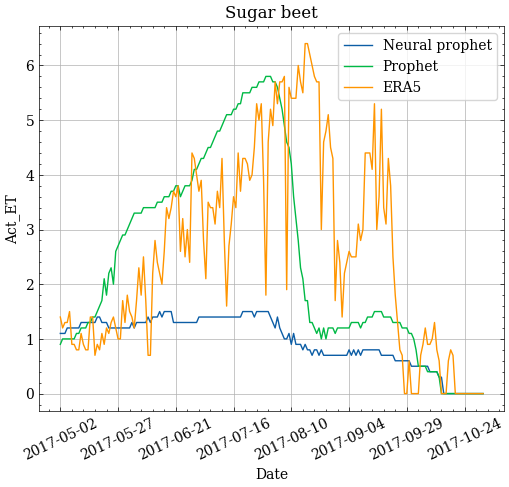

In [48]:
var = 'Act_ET'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [33]:
df['Yield'] = df['Yield'].astype(float)

In [37]:
crop = 'sugar beet/'
mask = df['Crop']==crop
sb = df.loc[mask]

In [42]:
sb.loc[:,'percent_error'] = (sb['Yield'] - sb.loc[sb['weather']=='era5', 'Yield']) / sb['Yield']* 100

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='weather', ylabel='percent_error'>

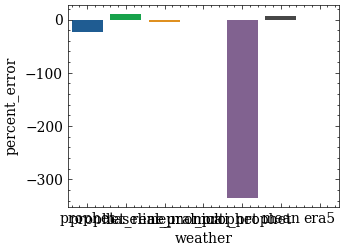

In [44]:
sb

sns.barplot(data=sb, x='weather', y='percent_error')

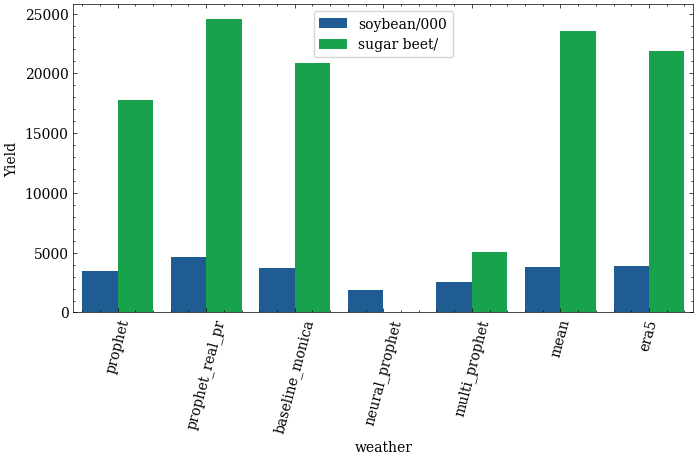

In [35]:
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='weather', y = 'Yield', hue='Crop')
plt.xticks(rotation=75)
plt.legend(frameon=True)
plt.show()

In [55]:
print(w_p.iloc[0:365,:]['precip'].sum())
print(np.sum(w_p.iloc[0:365,:]['precip']*1.2))

517.3336835849038
620.8004203018847


In [200]:
diff = 633 - 456
diff/365
w_p['precip'] = w_p['precip']+(diff/365)

In [201]:
df_w = pd.concat([w_p, w_np, w_mp, w_era, w_p_baseline, w_m, w_p_corr])



In [202]:
df_w.groupby('weather').mean().round(2)

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
Prophet+Hist,6.32,1.52,11.33,2.99,12.64,1.74,84.49
baseline_monica,6.01,1.45,10.42,3.05,12.04,1.74,81.77
era5,6.36,1.89,10.67,3.15,11.89,2.02,81.80
mean,6.03,1.46,10.45,3.06,12.10,1.74,81.64
multi_prophet,6.28,1.52,11.29,2.99,12.64,1.35,70.92
prophet,6.32,1.52,11.33,2.99,12.64,1.82,84.49
prophet_corr,6.32,1.52,11.33,2.99,12.64,1.72,84.49


In [167]:
diff = 633 - 456
diff/365

0.4849315068493151

In [168]:
mask = w_m['de-date']>'2017-01-01'
sum_precip = w_m.loc[mask, 'precip'].sum()

In [180]:
mask = df_w['de-date']>'2017-01-01'
df_w.loc[mask].round(2).groupby('weather').sum()

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
Prophet+Hist,2324.45,565.55,4201.70,1081.16,4628.95,456.53,29926.21
baseline_monica,2207.98,549.85,3812.12,1107.67,4386.83,633.54,29655.52
era5,2249.63,632.07,3802.09,1163.88,4349.21,666.18,29839.88
mean,2216.80,553.13,3826.31,1109.58,4409.56,633.67,29606.14
multi_prophet,2309.14,563.74,4182.24,1081.03,4629.47,460.48,24602.68
prophet,2324.45,565.55,4201.70,1081.16,4628.95,456.53,29926.21
prophet_corr,2324.45,565.55,4201.70,1081.16,4628.95,589.59,29926.21


In [17]:
w_p['precip'].min()

0.540182137326162

In [11]:
df_w.round(2).groupby('weather').sum() 

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
baseline_monica,6581.50,1590.06,11410.94,3344.83,13182.20,1904.96,89542.47
era5,6965.12,2066.63,11681.07,3452.16,13017.81,2216.00,89574.16
mean,6600.66,1594.02,11444.58,3349.47,13244.04,1909.95,89396.43
multi_prophet,6880.00,1662.41,12364.74,3278.21,13840.40,1474.03,77654.74
neural_prophet,7040.24,1878.18,12271.56,3304.80,13527.67,1008.83,83665.87
prophet,6916.25,1666.77,12408.97,3278.59,13839.12,1464.66,92511.19


In [54]:
df_mean = df_mean.set_index('de-date')
df_mean_train = df_mean.loc["2001-01-01":"2015-01-01"]

In [90]:
df_grouped = df_mean_train.groupby([df_mean_train.index.month, df_mean_train.index.day], as_index=False).mean()
df_grouped_std = df_mean_train.groupby([df_mean_train.index.month, df_mean_train.index.day], as_index=False).std()

In [74]:
df_grouped['de-date'] = pd.date_range(start='2015-01-01',end='2016-01-01')
df_grouped_std['de-date'] = pd.date_range(start='2015-01-01',end='2016-01-01')

In [96]:
mean_weather = pd.concat([df_grouped.iloc[:-1,:]]*3)
mean_weather['de-date'] = pd.date_range(start='2015-01-01',end='2017-12-30')
mean_weather = mean_weather.set_index('de-date').reset_index()

In [102]:
mean_weather.round(2).to_csv('../monica/mean_era5.csv', index=False)

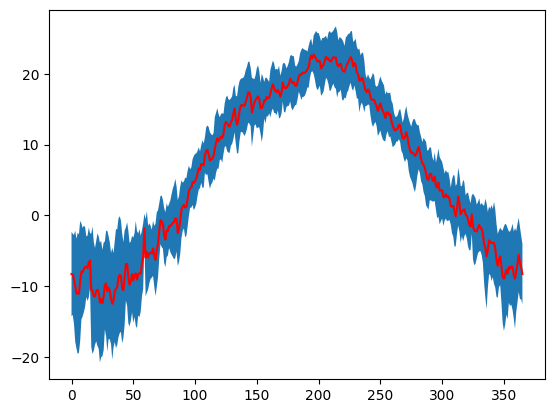

In [88]:
plt.plot(df_grouped['tavg'], c='r')
upper= df_grouped['tavg'] + df_grouped_std['tavg']
lower = df_grouped['tavg'] - df_grouped_std['tavg']
plt.fill_between(x=range(len(df_grouped)), y1=upper,
                y2=lower)

In [43]:
df_mean_train.index[0].year

2000